# Color discrimination

In [3]:
import cv2
import time
import math

import numpy as np

%matplotlib notebook 
import matplotlib.pyplot as plt
%matplotlib notebook

from bokeh.plotting import figure
from bokeh.io import output_notebook, show, push_notebook
from tqdm import tqdm

import IPython.display as Disp
from ipywidgets import widgets

In [4]:
# Live color detection for thymio

sensitivity = 15
lower_white = np.array([0,0,255-sensitivity])
upper_white = np.array([255,sensitivity,255])
color_infos=(0, 255, 255)
cap=cv2.VideoCapture(0)

# Get 1st frame of video 
ret, frame1 = cap.read()
#frame1 = cv2.cvtColor(frame1[:, :,:], cv2.COLOR_BGR2RGBA)
width, height = frame1.shape[1], frame1.shape[0]

# Extract vertexes, goals, thymio's start position and orientation from first frame 
# .
# .
# . 

# See on real set-up which is better between threshold or white color detection
# Add angle measurement function
while True:
    ret, frame=cap.read()
    #Preprocessing steps 
    
    image=cv2.cvtColor(frame, cv2.COLOR_BGR2HSV) 
    mask=cv2.inRange(image, lower_white, upper_white)
    image=cv2.blur(image, (7, 7))
    mask=cv2.erode(mask, None, iterations=4)
    mask=cv2.dilate(mask, None, iterations=4)
    
    #Extract white objects in image 
    
    image2=cv2.bitwise_and(frame, frame, mask=mask)
    contours=cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[-2]
    if len(contours) > 0:
        c=max(contours, key=cv2.contourArea)
        ((x, y), rayon)=cv2.minEnclosingCircle(c)
        if rayon>30:
            cv2.circle(image2, (int(x), int(y)), int(rayon), color_infos, 2)
            cv2.circle(frame, (int(x), int(y)), 5, color_infos, 10)
            cv2.line(frame, (int(x), int(y)), (int(x)+150, int(y)), color_infos, 2)
    cv2.imshow('Camera', frame)
    cv2.imshow('image2', image2)
    cv2.imshow('Mask', mask)
    if cv2.waitKey(1)&0xFF==ord('q'):
        break
        
cap.release()
cv2.destroyAllWindows()

<IPython.core.display.Javascript object>


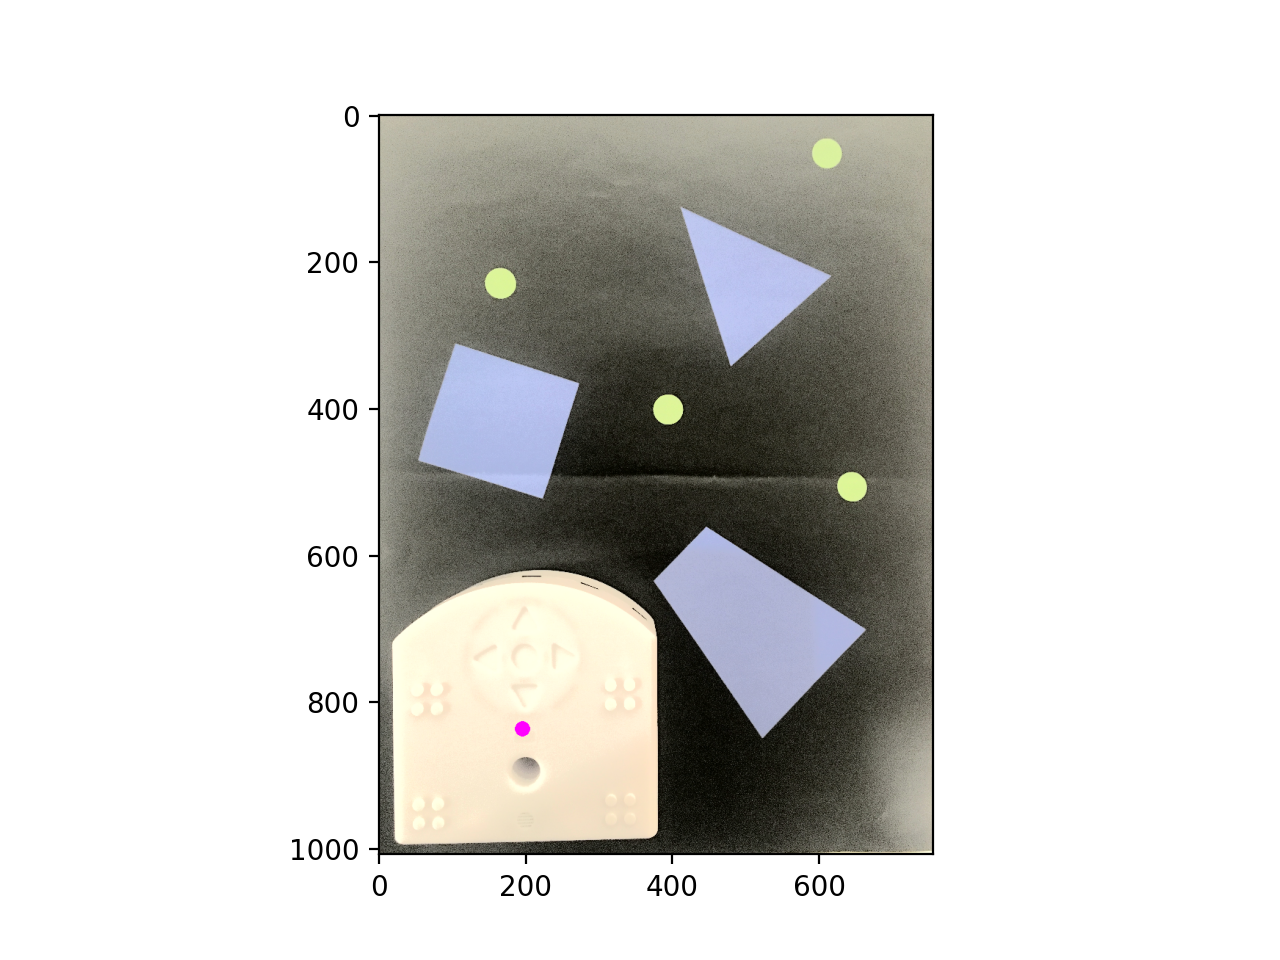

In [43]:
# Color detection for the first frame of the camera
# Could transform to matrix operation if need it to be faster 
def centroid(vertexes):
    x_list = [vertex [0][0] for vertex in vertexes]
    y_list = [vertex [0][1] for vertex in vertexes]
    length = len(vertexes)
    x = np.int0(sum(x_list) / length)
    y = np.int0(sum(y_list) / length)
    
    return(x, y)

# Expansion

def expand(centroid, vertexes):
    
    half_thymio = 20 # Thymio's half width
    new_corners = []
    
    for vertex in vertexes:
        dist = [(vertex[0][0] - centroid[0]), (vertex[0][1] - centroid[1])]
        angle = np.arctan2(dist[1], dist[0])
        new_coord = [vertex[0][0] + np.cos(angle)*half_thymio, vertex[0][1] + np.sin(angle)*half_thymio]
        new_corners.append(new_coord)
    
    new_corners = np.int0(new_corners)
    return new_corners

def color_detect(pic, low, high):
    
    image=cv2.cvtColor(pic, cv2.COLOR_BGR2HSV) 
    mask=cv2.inRange(pic, low, high)
    image=cv2.blur(pic, (5, 5))
    mask=cv2.erode(mask, None, iterations=4)
    mask=cv2.dilate(mask, None, iterations=4)
    
    color_img =cv2.bitwise_and(pic, pic, mask=mask)
    
    return color_img, mask

def goals(pic):
    
    low_green = np.array([130,100,50])
    high_green = np.array([150,255,255])
    goals_loc = []
    
    # Extract goals from original image through color detection
    img_goals, mask_goals = color_detect(pic, low_green, high_green)

    # Extract centers of goals 
    contours=cv2.findContours(mask_goals, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[-2]
    
    for cont in contours:
        #if len(contours) <= 0:
         #   print('No contours found for goals')
          #  return
        
        #c=max(contours, key=cv2.contourArea)
        ((x, y), rayon)=cv2.minEnclosingCircle(cont)
        goals_loc.append((x,y))
    
    goals_loc = np.int0(goals_loc)
    
    #draw centers of goals
    for cent in goals_loc:
        cv2.circle(img_goals, cent, 5, (255, 0, 0) , -1)
    
    return goals_loc,img_goals

def obstacles(img):
    
    low_blue = np.array([45,40,70])
    high_blue = np.array([110,255,255])
    corners=[]
    new_corners=[]
    centroids=[]
    img2 = img.copy()
    
    img_obst, mask_obst = color_detect(img, low_blue, high_blue)
    contours, hierarchy = cv2.findContours(mask_obst, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    #cv2.drawContours(image=img2, contours=contours, contourIdx=-1, color=(0, 255, 0), thickness=2, lineType=cv2.LINE_AA)
    
    for cont in contours:
        epsilon = 0.08 * cv2.arcLength(cont, True)
        approx = cv2.approxPolyDP(cont, epsilon, True)
        if(len(approx)>2):
            cv2.drawContours(img2, [approx], -1, (255, 0, 0), 2)
            corners.append(approx)

    # From extracted corners, define middle point of each object and create vertex (by 'expanding' corners)
    
    for i in range(0, len(corners)):
        centroids.append(centroid(corners[i]))
        #cv2.circle(poly_copy, centroids[i], 5, (255, 0, 0) , -1)# Just to check if the centroids are good
        new_corners.append(expand(centroids[i], corners[i]))   # Determine expanded corners (to take into account thymio width)    
    
        for corn in new_corners[i]:
            cv2.circle(img_obst, corn, 3, (255, 0, 0) , -1)

    return new_corners, img_obst

def PixToMm(thym_mask):
    
    circle_thym = thym_mask.copy()
    contours, hierarchy = cv2.findContours(circle_thym, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    #cv2.drawContours(image=circle_thym, contours=contours, contourIdx=-1, color=(0, 255, 0), thickness=2, lineType=cv2.LINE_AA)

    if len(contours) > 0:
        c=max(contours, key=cv2.contourArea)
        ((x, y), rayon)=cv2.minEnclosingCircle(c)
        print(rayon)
        cv2.circle(circle_thym, (int(x), int(y)), int(rayon), (0, 0, 255), 2)
            #cv2.circle(frame, (int(x), int(y)), 5, color_infos, 10)
    
    PixToMm = 140/(2*rayon)
    
    return PixToMm, thym_mask-circle_thym

def Start(img):
    
    # Histogram equalization
    img_yuv = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
    img_yuv[:,:,0] = cv2.equalizeHist(img_yuv[:,:,0])
    img_output = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2BGR)
    
    # Thresholding (get white pixels = Thymio)
    img_white = cv2.cvtColor(img_output, cv2.COLOR_RGB2GRAY) 
    img_white=cv2.blur(img_white, (5, 5))
    ret,img_white = cv2.threshold(img_white,220, 255,cv2.THRESH_BINARY)
    
    contours, hierarchy = cv2.findContours(img_white, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    #cv2.drawContours(image=circle_thym, contours=contours, contourIdx=-1, color=(0, 255, 0), thickness=2, lineType=cv2.LINE_AA)

    if len(contours) > 0:
        c=max(contours, key=cv2.contourArea)
        ((x, y), rayon)=cv2.minEnclosingCircle(c)
        cv2.circle(img_output, (int(x), int(y)), 5, (255, 0, 255), 10)
            #cv2.circle(frame, (int(x), int(y)), 5, color_infos, 10)
    
    start = (x,y)
    
    return start, img_output
    
img = cv2.imread('images/colors.JPG', cv2.IMREAD_COLOR)
img=cv2.cvtColor(img, cv2.COLOR_RGB2BGR) 
img = cv2.resize(img, None,fx=0.25, fy=0.25, interpolation = cv2.INTER_CUBIC)

sensitivity = 15
low_white = np.array([0,0,50])
high_white = np.array([255,50,255])


# Extract goals using color detection + find their centers

center_goals, img_goals = goals(img)
vertexes, img_obst = obstacles(img)

# Extract thymio start

#img_thymio, mask_thym = color_detect(img_output, low_white, high_white)
#PixToMm, circle_thym = PixToMm(img_white)
start_pos, start_thym = Start(img)

plt.figure()
plt.imshow(start_thym)

# Angle estimation

In [5]:
def angle(pic):
    
    low_blue = np.array([45,20,70])
    high_blue = np.array([108,255,255])

    corners = [(0,0), (0,0)]
    centers = []
    
    img_angle, mask_angle = color_detect(img, low_blue, high_blue)
    contours, hierarchy = cv2.findContours(mask_angle, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    #cv2.drawContours(image=img, contours=contours, contourIdx=-1, color=(0, 255, 0), thickness=2, lineType=cv2.LINE_AA)
 
    for cont in contours:
        
        epsilon = 0.1 * cv2.arcLength(cont, True)
        approx = cv2.approxPolyDP(cont, epsilon, True)
        if(len(approx)>2):
            if(len(approx)==3):
                corners[0] = approx
            if(len(approx)==4):
                corners[1] = approx
    
    for i in range(0, len(corners)):
        centers.append(centroid(corners[i]))

    diff = [centers[0][0]-centers[1][0], centers[0][1]-centers[1][1]]
    angle = math.degrees(np.arctan2(diff[1], diff[0])%(2*np.pi))
    
    return angle

img = cv2.imread('images/angles2.JPG', cv2.IMREAD_COLOR)
img=cv2.cvtColor(img, cv2.COLOR_RGB2BGR) 
img = cv2.resize(img, None,fx=0.25, fy=0.25, interpolation = cv2.INTER_CUBIC)

angle = angle(img)
print(angle)


311.8201698801358


# Vertex detection

Image Loaded


<IPython.core.display.Javascript object>


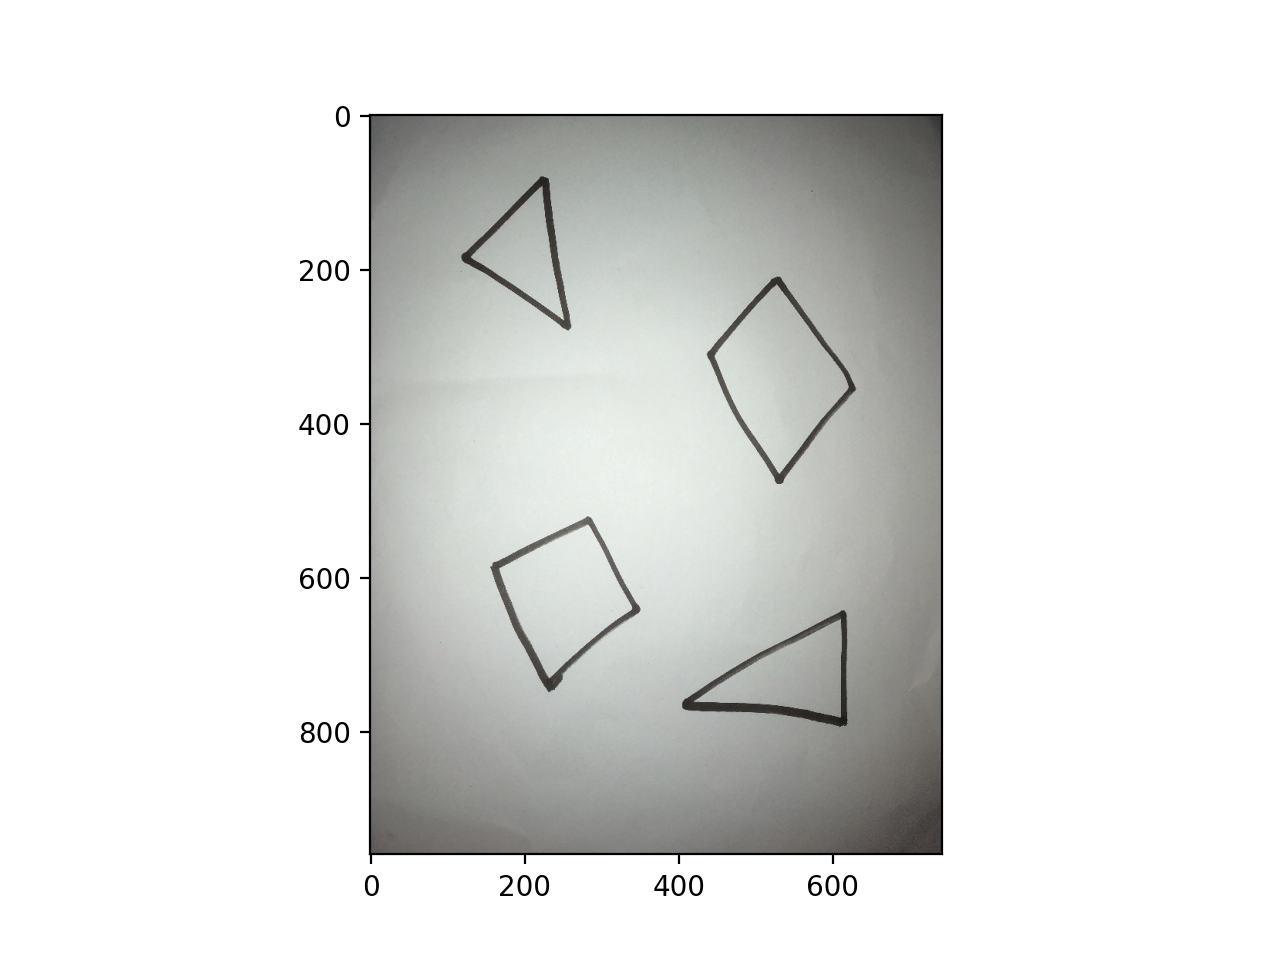

In [23]:
img = cv2.imread('images/shapes_img.JPG', cv2.IMREAD_COLOR)
img = cv2.resize(img, None,fx=0.25, fy=0.25, interpolation = cv2.INTER_CUBIC)
img2 = []

# If the image path is wrong, the resulting img will be none
if img is None:
    print('Open Error')
else:
    print('Image Loaded')
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.figure()
plt.imshow(img)

In [3]:
'''#Try new method to extract corners
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
bi = gray#cv2.bilateralFilter(gray, 5, 75, 75)
dst = cv2.cornerHarris(bi, 4, 3, 0.08)
mask = np.zeros_like(gray)

mask[dst>0.05*dst.max()] = 255
img[dst > 0.01 * dst.max()] = [255, 0, 0]

fig, ax = plt.subplots(1,2, figsize=(7,4))
ax[0].imshow(mask)
ax[0].set_title('mask')

ax[1].imshow(img)
ax[1].set_title('img')

plt.tight_layout()
plt.show()'''

"#Try new method to extract corners\ngray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)\nbi = gray#cv2.bilateralFilter(gray, 5, 75, 75)\ndst = cv2.cornerHarris(bi, 4, 3, 0.08)\nmask = np.zeros_like(gray)\n\nmask[dst>0.05*dst.max()] = 255\nimg[dst > 0.01 * dst.max()] = [255, 0, 0]\n\nfig, ax = plt.subplots(1,2, figsize=(7,4))\nax[0].imshow(mask)\nax[0].set_title('mask')\n\nax[1].imshow(img)\nax[1].set_title('img')\n\nplt.tight_layout()\nplt.show()"

<IPython.core.display.Javascript object>


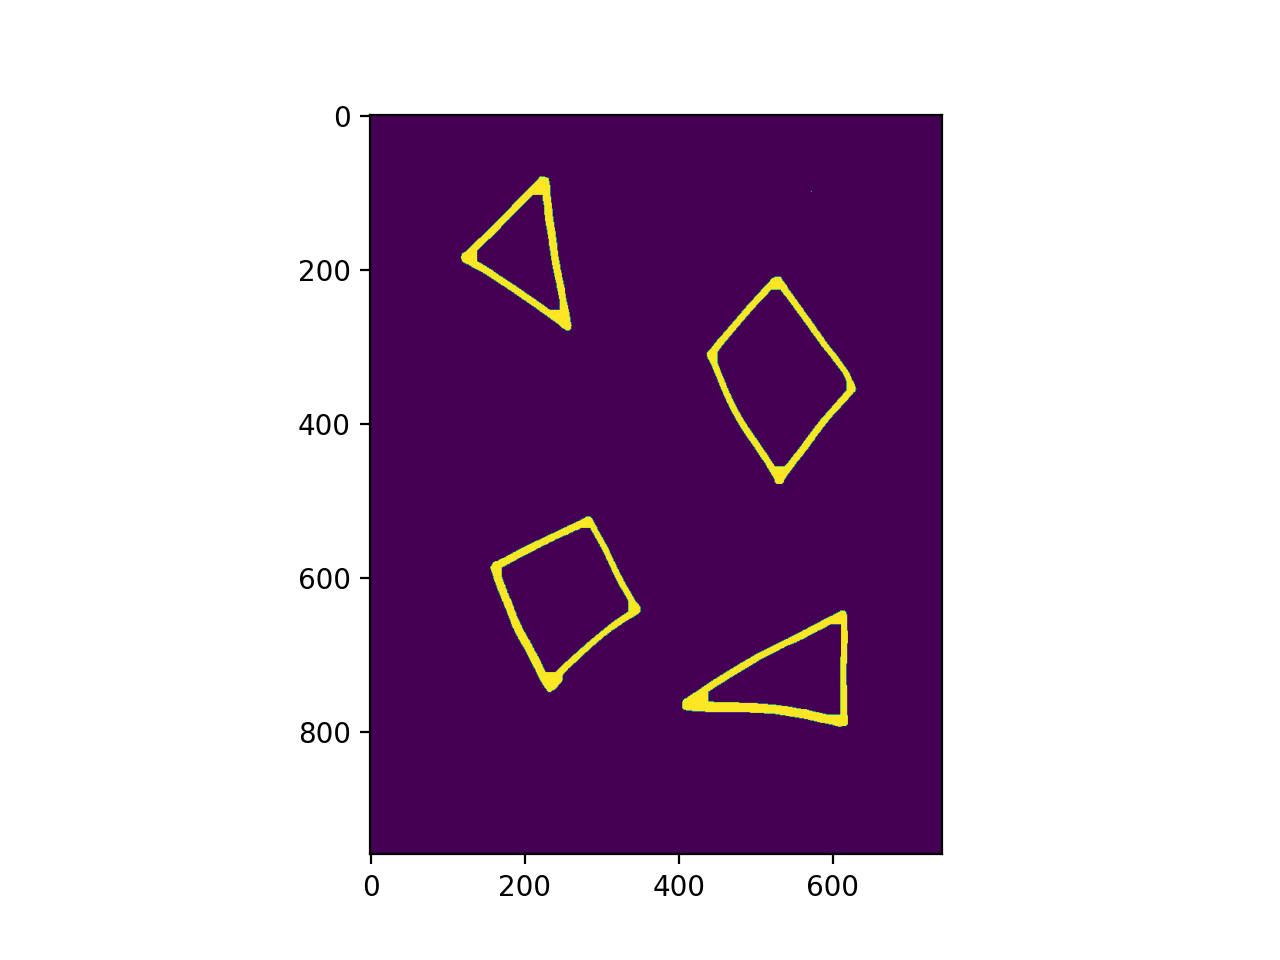

"ret,th1 = cv2.threshold(img_gray,120, 220,cv2.THRESH_BINARY)\ntitles = ['Original Image', 'Binary Threshold']\nimages = [img_gray, th1]\nplt.figure(figsize=(8,5))\nplt.imshow(images[0],'gray')\nplt.title(titles[0])\nplt.imshow(images[1],'gray')\nplt.title(titles[1])"

In [24]:
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img_blur = cv2.GaussianBlur(img_gray, (5,5), 1)
img_canny = cv2.Canny(img_blur, 100, 100)
kernel = np.ones((5,5))
img_dial = cv2.dilate(img_canny, kernel, iterations=3)
img_th = cv2.erode(img_dial, kernel, iterations=3)

plt.figure()
plt.imshow(img_th)

'''ret,th1 = cv2.threshold(img_gray,120, 220,cv2.THRESH_BINARY)
titles = ['Original Image', 'Binary Threshold']
images = [img_gray, th1]
plt.figure(figsize=(8,5))
plt.imshow(images[0],'gray')
plt.title(titles[0])
plt.imshow(images[1],'gray')
plt.title(titles[1])'''


<IPython.core.display.Javascript object>


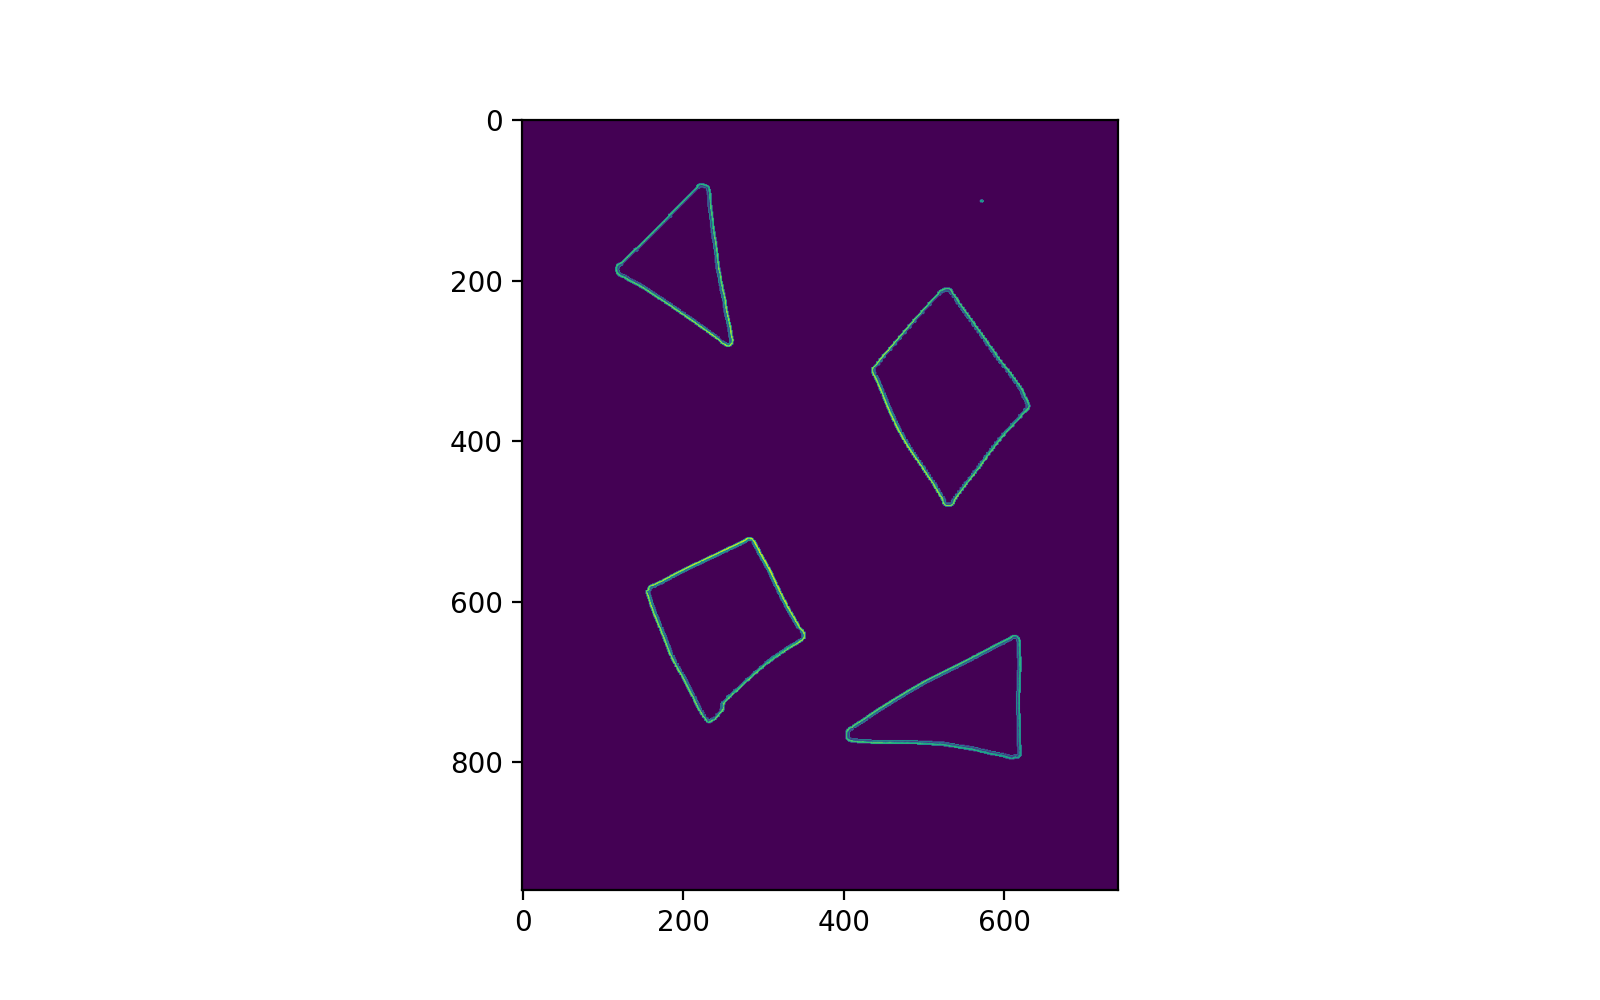

uint8


In [25]:
img2 = img.copy()

contours, hierarchy = cv2.findContours(img_th, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cv2.drawContours(image=img2, contours=contours, contourIdx=-1, color=(0, 255, 0), thickness=2, lineType=cv2.LINE_AA)
plt.figure(figsize = (8,5))
plt.imshow(img - img2)

img_cont = img - img2
img_cont = cv2.cvtColor(img_cont, cv2.COLOR_RGB2GRAY)
print(img_cont.dtype)
plt.imshow(img_cont)

5
[[156 587]]
3


<IPython.core.display.Javascript object>


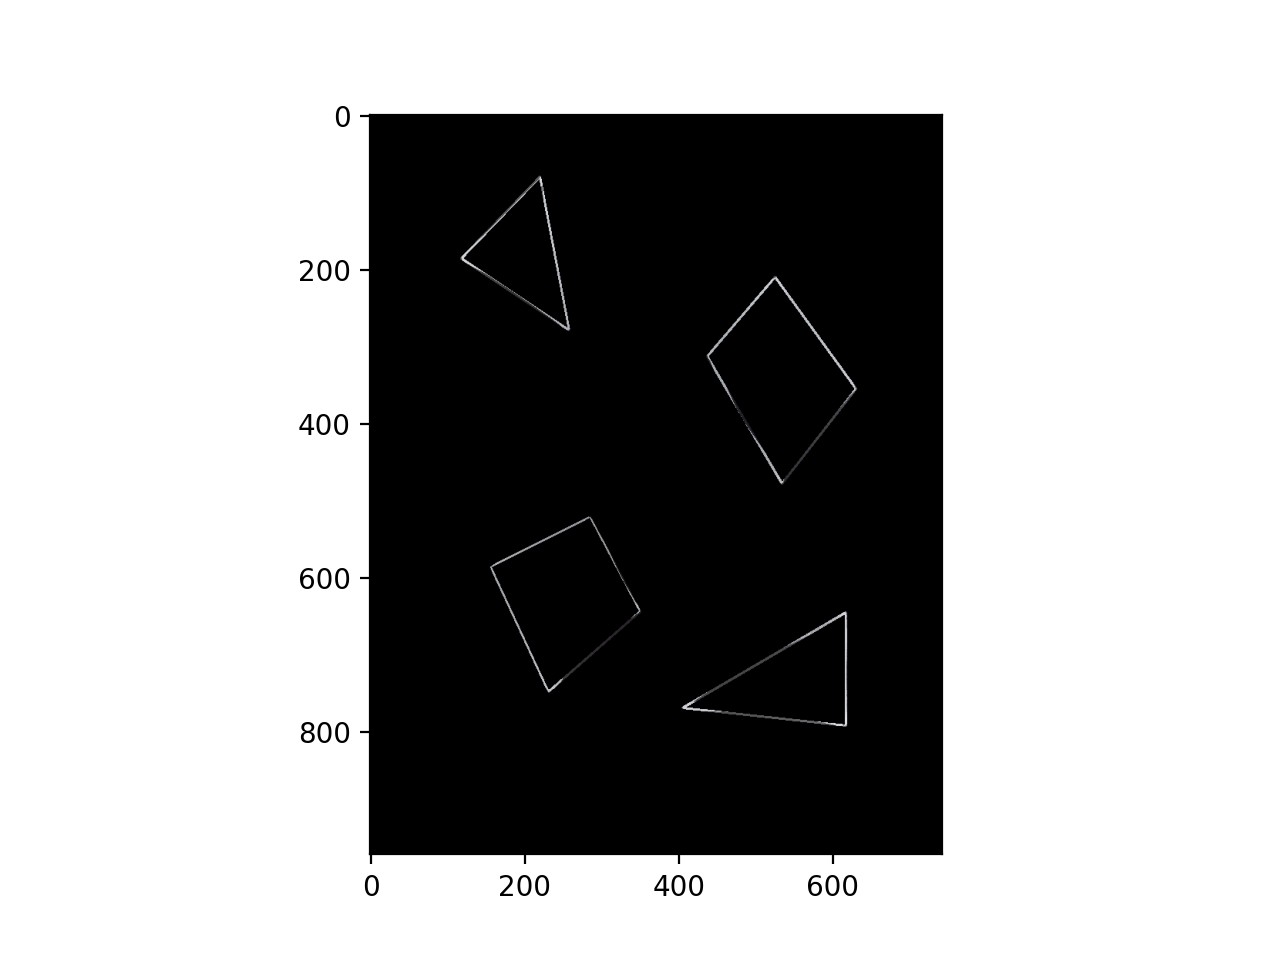

In [26]:
# Transform to polygon and determine corners 
img3 = img.copy()
print(len(contours))
corners = []
for cont in contours:
    
    epsilon = 0.1 * cv2.arcLength(cont, True)
    approx = cv2.approxPolyDP(cont, epsilon, True)
    if(len(approx)>2):
        cv2.drawContours(img3, [approx], -1, (255, 0, 0), 2)
        corners.append(approx)
        
print(corners[1][1])
print(len(corners[0]))
img_poly = img3 - img
plt.figure()
plt.imshow(img3 - img)


In [5]:
# From extracted corners, define middle point of each object and create vertex (by 'expanding' corners)
# Could transform to matrix operation if need it to be faster 
def centroid(vertexes):
    x_list = [vertex [0][0] for vertex in vertexes]
    y_list = [vertex [0][1] for vertex in vertexes]
    length = len(vertexes)
    x = np.int0(sum(x_list) / length)
    y = np.int0(sum(y_list) / length)
    
    return(x, y)

# Expansion

def expand(centroid, vertexes):
    
    half_thymio = 20 # Thymio's half width
    new_corners = []
    
    for vertex in vertexes:
        dist = [(vertex[0][0] - centroid[0]), (vertex[0][1] - centroid[1])]
        angle = np.arctan2(dist[1], dist[0])
        new_coord = [vertex[0][0] + np.cos(angle)*half_thymio, vertex[0][1] + np.sin(angle)*half_thymio]
        new_corners.append(new_coord)
    
    new_corners = np.int0(new_corners)
    return new_corners

centroids = []
new_corners = []
poly_copy = img_poly.copy()

for i in range(0, len(corners)):

    centroids.append(centroid(corners[i]))
    cv2.circle(poly_copy, centroids[i], 5, (255, 0, 0) , -1)# Just to check if the centroids are good
    new_corners.append(expand(centroids[i], corners[i]))   # Determine expanded corners (to take into account thymio width)    
    
    for corn in new_corners[i]:
        cv2.circle(poly_copy, corn, 3, (255, 0, 0) , -1)

plt.figure()
plt.imshow(poly_copy)


NameError: name 'img_poly' is not defined

In [17]:
plt.close('all')

In [8]:
'''corners = []
img_poly = np.uint8(img_poly)
corners = cv2.cornerHarris(img_poly, 2, 3, 0.04)
mask = np.zeros_like(img_poly)
mask[corners>0.1*corners.max()] = 255
plt.figure()
plt.imshow(mask)

img_poly = np.float32(img_poly)
dst = cv2.cornerHarris(img_poly,5,3,0.04)
ret, dst = cv2.threshold(dst,0.1*dst.max(),255,0)
dst = np.uint8(dst)
ret, labels, stats, centroids = cv2.connectedComponentsWithStats(dst)
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.001)
corners = cv2.cornerSubPix(th1,np.float32(centroids),(5,5),(-1,-1),criteria)
for i in range(1, len(corners)):
    print(corners[i])
corn[dst>0.1*dst.max()]=[0,0,255]
plt.figure()
plt.imshow(corn)
cv2.waitKey(0)
cv2.destroyAllWindows'''

'corners = []\nimg_poly = np.uint8(img_poly)\ncorners = cv2.cornerHarris(img_poly, 2, 3, 0.04)\nmask = np.zeros_like(img_poly)\nmask[corners>0.1*corners.max()] = 255\nplt.figure()\nplt.imshow(mask)\n\nimg_poly = np.float32(img_poly)\ndst = cv2.cornerHarris(img_poly,5,3,0.04)\nret, dst = cv2.threshold(dst,0.1*dst.max(),255,0)\ndst = np.uint8(dst)\nret, labels, stats, centroids = cv2.connectedComponentsWithStats(dst)\ncriteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.001)\ncorners = cv2.cornerSubPix(th1,np.float32(centroids),(5,5),(-1,-1),criteria)\nfor i in range(1, len(corners)):\n    print(corners[i])\ncorn[dst>0.1*dst.max()]=[0,0,255]\nplt.figure()\nplt.imshow(corn)\ncv2.waitKey(0)\ncv2.destroyAllWindows'

# Tracking

In [2]:
from random import randint
 
trackerTypes = ['BOOSTING', 'MIL', 'KCF','TLD', 'MEDIANFLOW', 'GOTURN', 'MOSSE', 'CSRT']
 
def createTrackerByName(trackerType):
    # Create a tracker based on tracker name
    if trackerType == trackerTypes[0]:
        tracker = cv2.TrackerBoosting_create()
    elif trackerType == trackerTypes[1]: 
        tracker = cv2.TrackerMIL_create()
    elif trackerType == trackerTypes[2]:
        tracker = cv2.TrackerKCF_create()
    elif trackerType == trackerTypes[3]:
        tracker = cv2.TrackerTLD_create()
    elif trackerType == trackerTypes[4]:
        tracker = cv2.TrackerMedianFlow_create()
    elif trackerType == trackerTypes[5]:
        tracker = cv2.TrackerGOTURN_create()
    elif trackerType == trackerTypes[6]:
        tracker = cv2.TrackerMOSSE_create()
    elif trackerType == trackerTypes[7]:
        tracker = cv2.legacy.TrackerCSRT_create()
    else:
        tracker = None
        print('Incorrect tracker name')
        print('Available trackers are:')
        for t in trackerTypes:
            print(t)

    return tracker

In [3]:
# Create a video capture object to read videos
cap = cv2.VideoCapture('images/thymio_mov_480p.mov')
 
# Read first frame
success, frame = cap.read()

width, height = frame.shape[1], frame.shape[0]

# quit if unable to read the video file
if not success:
    print('Failed to read video')
    sys.exit(1)

In [4]:
## Select boxes
bboxes = []
colors = [] 
 
# OpenCV's selectROI function doesn't work for selecting multiple objects in Python
# So we will call this function in a loop till we are done selecting all objects
i = 0

while True:
    print("Ready to select new ROI")
    i += 1
    # draw bounding boxes over objects
    # selectROI's default behaviour is to draw box starting from the center
    # when fromCenter is set to false, you can draw box starting from top left corner
    bbox = cv2.selectROI('MultiTracker', frame)
    bboxes.append(bbox)
    colors.append((randint(0, 255), randint(0, 255), randint(0, 255)))
    print("Object {}, bbox {}".format(i, bbox))
    print("Press **q** to quit selecting boxes and start tracking")
    print("Press any other key to select next object \n")
    k = cv2.waitKey(0) & 0xFF
    if (k == 113):  # q is pressed
        break

print('Selected bounding boxes {}'.format(bboxes))
cv2.destroyAllWindows()

Ready to select new ROI
Object 1, bbox (369, 199, 80, 75)
Press **q** to quit selecting boxes and start tracking
Press any other key to select next object 

Selected bounding boxes [(369, 199, 80, 75)]


In [5]:
# Instead of MIL, you can also use
# BOOSTING, KCF, TLD, MEDIANFLOW or GOTURN
# Specify the tracker type
trackerType = "CSRT"   
 
# Create MultiTracker object
multiTracker = cv2.legacy.MultiTracker_create()
 
# Initialize MultiTracker 
for bbox in bboxes:
    multiTracker.add(createTrackerByName(trackerType), frame, bbox)

In [6]:
# Creating the plot
#p = figure(x_range=(0,width), y_range=(0,height), output_backend="webgl", width=width, height=height)
#myImage = p.image_rgba(image=[frame], x=0, y=0, dw=width, dh=height)
#show(p, notebook_handle=True)

# Process video and track objects
while cap.isOpened():
    success, frame = cap.read()
    if not success:
        break

    # get updated location of objects in subsequent frames
    success, boxes = multiTracker.update(frame)

    # draw tracked objects
    for i, newbox in enumerate(boxes):
        p1 = (int(newbox[0]), int(newbox[1]))
        p2 = (int(newbox[0] + newbox[2]), int(newbox[1] + newbox[3]))
        cv2.rectangle(frame, p1, p2, colors[i], 2, 1)

    # show frame
    #cv2.imshow('MultiTracker', frame)
    frame=cv2.cvtColor(frame, cv2.COLOR_BGR2RGBA)
    cv2.imshow('Frame',frame)
    time.sleep(0.01)
    # quit on ESC button
    if cv2.waitKey(1) & 0xFF == 27:  # Esc pressed
        break

# When everything done, release the video capture object
cap.release()

print("Done displaying the video")

Done displaying the video
